# One-dimensional Poisson-Nernst-Planck systems

The `matscipy.electrochemistry.PoissonNernstPlanckSystem` solver provides an interface for solving classical, one-dimensional electrochemical systems with an arbitrary number of $N$ ionic species by means of a controlled-volumes method.

## The inert electrode

An archetypical system is the inert electrode at the open half-space governed by the Poisson equation and $N$ Nernst-Planck equations with Dirichlet and Neumann boundary conditions as shown in <a href="#figure1">Figure 1</a> below.

<a id="figure1"></a><figure>
![Figure 1](electrochemistry/inertElectrode.svg)

*Figure 1*: Inert electrode at the open half-space

Here, $D_i$ is the diffusivity of the *i*th species, $c_i$ its local concentration, $c_i^\infty$ its bulk concentration, $u_i$ its electric mobility, and $z_i$ its charge number. $\phi$ is the local electrostatic potential, and $\phi_0$ the electrode's potential compared to the bulk solution. $\epsilon_0$ is the vacuum permittivity, $\epsilon_r$ is the relative permittivity of the solvent, and $F$ is the Faraday constant.

In the following, we use `matscipy.electrochemistry.PoissonNernstPlanckSystem` to solve this system for $0.1\,\mathrm{mM}~\text{NaCl}$ at $0.05\,\mathrm{V}$ bias. Parameters are provided in SI units. We will compare the results against the analytical solution, which exists for this special case of a binary electrolyte.

### Preparations

First, we import a few basic tools.

In [34]:
import numpy as np
import scipy.constants as sc
import matplotlib.pyplot as plt

Then, we import the Poisson-Nernst-Planck solver.

In [2]:
from matscipy.electrochemistry import PoissonNernstPlanckSystem

### System initialization and solving

In [3]:
c = [0.1, 0.1] # bulk concentrations of ion species Na and Cl in mM
z = [1, -1] # number charges of ion species
L = 1e-07 # interval length in m
delta_u = 0.05

The log output of the system's initialization will show all provided and derived parameters such as the discretization grid as well as their dimensionless values.

In [4]:
pnp = PoissonNernstPlanckSystem(c=c, z=z, L=L, delta_u=delta_u)

The method `useStandardInterfaceBC` will apply boundary conditions as shown in <a hef="#figure1">Figure 1</a>.

In [5]:
pnp.useStandardInterfaceBC()
ui, nij, _ = pnp.solve()

`ui` holds the electrostatic potential at the discretization points and `nij` the species concentrations at the discretization points.

### Validation: Analytical half-space solution vs. numerical finite-interval PNP system

`matscipy.electrochemistry` provides a function for quickly retrieving the Debye length $\lambda_D$ of an electrolyte.

In [6]:
from matscipy.electrochemistry import debye
deb = debye(c, z)

The analytical solution for the open half-space at an inert electrode is just the Possion-Boltzmann disribution [[3]](#israelachvili1991). `matscipy.electrochemistry.poisson_boltzmann_distribution` provides a few short-hand functions for retrieving electrostatic potential, charge density and concentrations that arise from this analaytical solution.

In [7]:
from matscipy.electrochemistry.poisson_boltzmann_distribution import potential, concentration, charge_density

x = np.linspace(0, L, 100)
phi = potential(x, c, z, delta_u) 
C =   concentration(x, c, z, delta_u)
rho = charge_density(x, c, z, delta_u) 

We define a little helper for a prettifying ourt plot.

In [8]:
def make_patch_spines_invisible(ax):
    ax.set_frame_on(True)
    ax.patch.set_visible(False)
    for sp in ax.spines.values():
        sp.set_visible(False)

Next, we hold analytical Poisson-Boltzmann (PB) results on the infinite half space and numerical Poisson-Nernst-Planck (PNP) results on the limited interval next to each other and are convinced of the solution's validity.

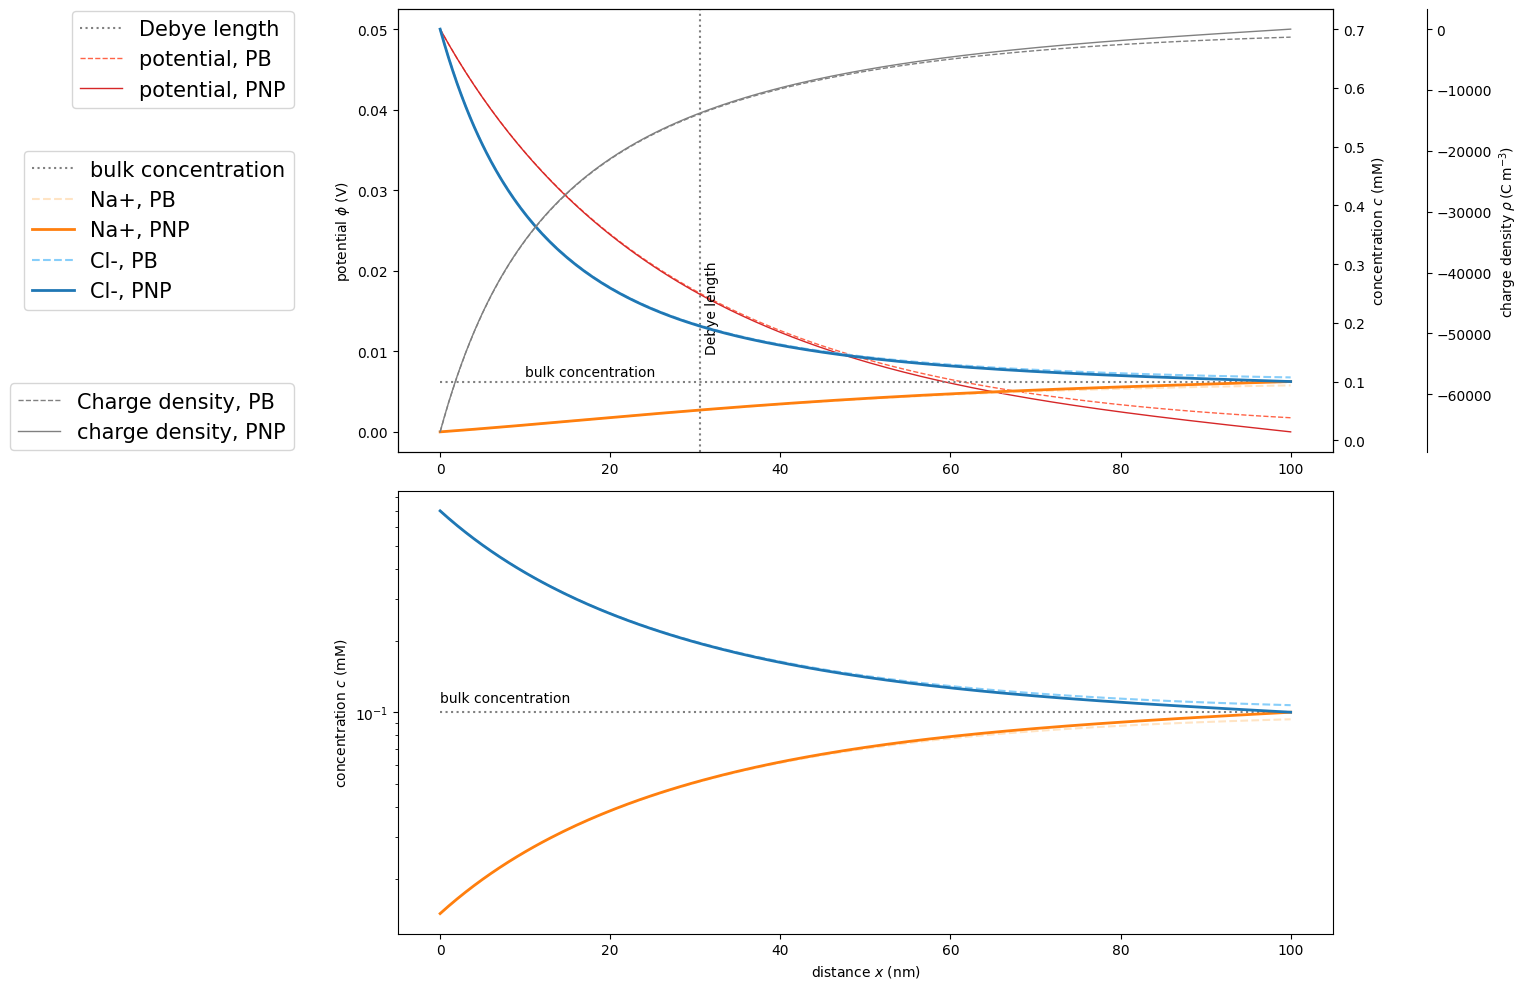

In [9]:
fig, (ax1,ax4) = plt.subplots(nrows=2,ncols=1,figsize=[16,10])
ax1.axvline(x=deb/sc.nano, label='Debye length', color='grey', linestyle=':')
ax1.text(deb/sc.nano*1.02, 0.01, "Debye length", rotation=90)

ax1.plot(x/sc.nano, phi, marker='', color='tomato', label='potential, PB', linewidth=1, linestyle='--')
ax1.plot(pnp.grid/sc.nano, pnp.potential, marker='', color='tab:red', label='potential, PNP', linewidth=1, linestyle='-')

ax2 = ax1.twinx()
ax2.plot(x/sc.nano, np.ones(x.shape)*c[0], label='bulk concentration', color='grey', linestyle=':')
ax2.text(10, c[0]*1.1, "bulk concentration")

ax2.plot(x/sc.nano, C[0], marker='', color='bisque', label='Na+, PB',linestyle='--')
ax2.plot(pnp.grid/sc.nano, pnp.concentration[0], marker='', color='tab:orange', label='Na+, PNP', linewidth=2, linestyle='-')

ax2.plot(x/sc.nano, C[1], marker='', color='lightskyblue', label='Cl-, PB',linestyle='--')
ax2.plot(pnp.grid/sc.nano, pnp.concentration[1], marker='', color='tab:blue', label='Cl-, PNP', linewidth=2, linestyle='-')

ax3 = ax1.twinx()
# Offset the right spine of ax3.  The ticks and label have already been
# placed on the right by twinx above.
ax3.spines["right"].set_position(("axes", 1.1))

# Having been created by twinx, ax3 has its frame off, so the line of its
# detached spine is invisible. First, activate the frame but make the patch
# and spines invisible.
make_patch_spines_invisible(ax3)

# Second, show the right spine.
ax3.spines["right"].set_visible(True)

ax3.plot(x/sc.nano, rho, label='Charge density, PB', color='grey', linewidth=1, linestyle='--')
ax3.plot(pnp.grid/sc.nano, pnp.charge_density, label='charge density, PNP', color='grey', linewidth=1, linestyle='-')

ax4.semilogy(x/sc.nano, np.ones(x.shape)*c[0], label='bulk concentration', color='grey', linestyle=':')
ax4.text(0, c[0]*1.1, "bulk concentration")
ax4.semilogy(x/sc.nano, C[0], marker='', color='bisque', label='Na+, PB',linestyle='--')
ax4.semilogy(pnp.grid/sc.nano, pnp.concentration[0], marker='', color='tab:orange', label='Na+, PNP', linewidth=2, linestyle='-')

ax4.semilogy(x/sc.nano, C[1], marker='', color='lightskyblue', label='Cl-, PB',linestyle='--')
ax4.semilogy(pnp.grid/sc.nano, pnp.concentration[1], marker='', color='tab:blue', label='Cl-, PNP', linewidth=2, linestyle='-')

ax1.set_ylabel('potential $\phi$ (V)')
ax2.set_ylabel('concentration $c$ (mM)')
ax3.set_ylabel(r'charge density $\rho \> (\mathrm{C}\> \mathrm{m}^{-3})$')
ax4.set_ylabel('concentration $c$ (mM)')
ax4.set_xlabel('distance $x$ (nm)')

ax1.legend(loc='upper right',  bbox_to_anchor=(-0.1,1.02), fontsize=15)
ax2.legend(loc='center right', bbox_to_anchor=(-0.1,0.5),  fontsize=15)
ax3.legend(loc='lower right',  bbox_to_anchor=(-0.1,-0.02), fontsize=15)

fig.tight_layout()
plt.show()

## The electrochemical cell

Another archetypical system is the one-dimensional electrochemical cell governed by Neumann and Robin boundary conditions as shown below in <a href="#figure2">Figure 2</a>.

<a id="figure2"></a><figure>
![Figure 2](electrochemistry/electrochemicalCellBazant1d.svg)

*Figure 2*: One-dimensional electrochemical cell after Bazant <a href="#bazant2006">[1]</a>

Here, $i_\text{cell}$ is the total density of Faradaic current through the cell that arises due to $M$ half-reactions, with $i_j$ the partial current due to reaction $j$. $\nu_{ij}$ is the stochiometric coefficient of species $i$, and $n_j$ the number of electrons participating in half-reaction $j$. $\lambda_S$ is the width of a compact Stern layer. The assumption of a compact Stern layer [[2]](#stern1924) reduces the system's strong nonlinearity close to the electrode and may facilitate convergence.

### System initialization and solving: Dirichlet and Neumann boundary conditions

Again, we solve this system for inert electrodes, i.e. in the absence of any current flux with the same parameters as above.

In [10]:
c = [0.1, 0.1] # bulk concentrations of ion species Na and Cl in mM
z = [1, -1] # number charges of ion species
L = 1e-07 # interval length in m
delta_u = 0.05 # electrostatic potential bias

pnp = PoissonNernstPlanckSystem(c=c, z=z, L=L, delta_u=delta_u)

The only difference is the application of another set of predefined boundary conditions.

In [11]:
pnp.useStandardCellBC()

These boundary conditions assume no Stern layer, i.e. $\lambda_S = 0$

In [12]:
pnp.output = True
xij = pnp.solve()

### Visualization

We show the results in the familiar manner.

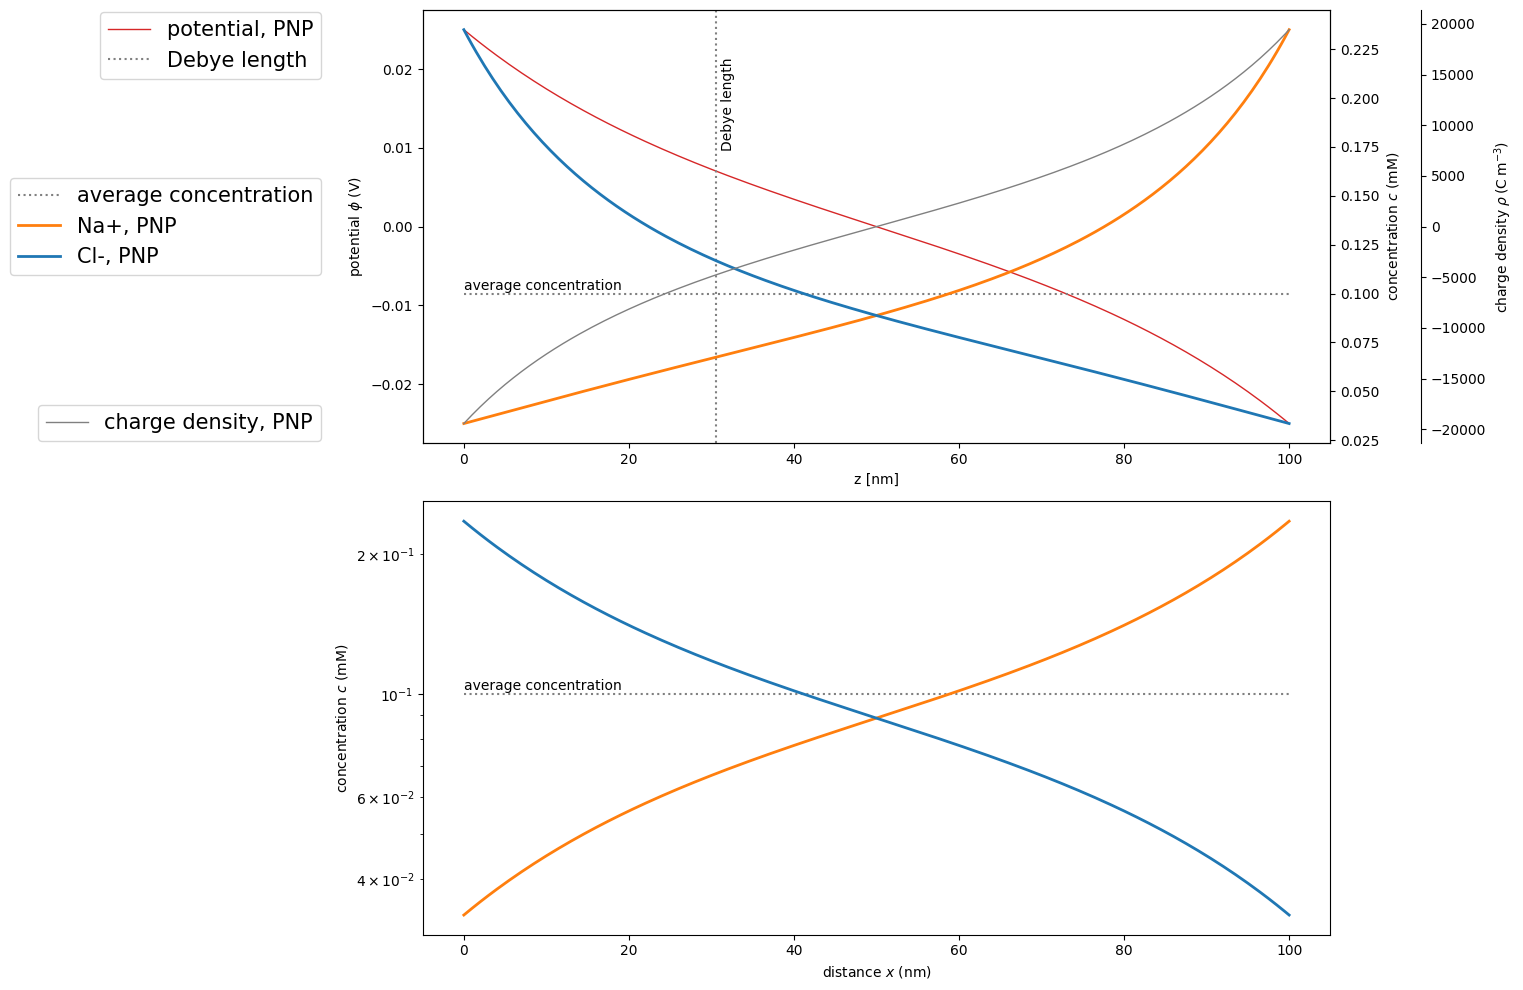

In [13]:
x = np.linspace(0, L, 100)

deb = debye(c, z)

fig, (ax1,ax4) = plt.subplots(nrows=2,ncols=1,figsize=[16,10])
ax1.set_xlabel('z [nm]')
ax1.plot(pnp.grid/sc.nano, pnp.potential, marker='', color='tab:red', label='potential, PNP', linewidth=1, linestyle='-')

ax2 = ax1.twinx()
ax2.plot(x/sc.nano, np.ones(x.shape)*c[0], label='average concentration', color='grey', linestyle=':')
ax2.text(0, c[0]*1.02, "average concentration")

ax2.plot(pnp.grid/sc.nano, pnp.concentration[0], marker='', color='tab:orange', label='Na+, PNP', linewidth=2, linestyle='-')

ax2.plot(pnp.grid/sc.nano, pnp.concentration[1], marker='', color='tab:blue', label='Cl-, PNP', linewidth=2, linestyle='-')
ax1.axvline(x=deb/sc.nano, label='Debye length', color='grey', linestyle=':')
ax1.text(deb/sc.nano*1.02, 0.01, "Debye length", rotation=90)

ax3 = ax1.twinx()
ax3.spines["right"].set_position(("axes", 1.1))
make_patch_spines_invisible(ax3)

ax3.spines["right"].set_visible(True)
ax3.plot(pnp.grid/sc.nano, pnp.charge_density, label='charge density, PNP', color='grey', linewidth=1, linestyle='-')

ax4.semilogy(x/sc.nano, np.ones(x.shape)*c[0], label='average concentration', color='grey', linestyle=':')
ax4.text(0, c[0]*1.02, "average concentration")
ax4.semilogy(pnp.grid/sc.nano, pnp.concentration[0], marker='', color='tab:orange', label='Na+, PNP', linewidth=2, linestyle='-')
ax4.semilogy(pnp.grid/sc.nano, pnp.concentration[1], marker='', color='tab:blue', label='Cl-, PNP', linewidth=2, linestyle='-')

ax1.set_ylabel('potential $\phi$ (V)')
ax2.set_ylabel('concentration $c$ (mM)')
ax3.set_ylabel(r'charge density $\rho \> (\mathrm{C}\> \mathrm{m}^{-3})$')
ax4.set_ylabel('concentration $c$ (mM)')
ax4.set_xlabel('distance $x$ (nm)')

ax1.legend(loc='upper right',  bbox_to_anchor=(-0.1,1.02), fontsize=15)
ax2.legend(loc='center right', bbox_to_anchor=(-0.1,0.5),  fontsize=15)
ax3.legend(loc='lower right',  bbox_to_anchor=(-0.1,-0.02), fontsize=15)

fig.tight_layout()
plt.show()

# From continuous double layer theory to discrete coordinate sets

### Poisson-Nernst-Planck-System with Stern layer boundary conditions

In this example We want to fill a gap of 5 nm between gold electrodes with 0.2 wt % NaCl aqueous solution, apply a small potential difference and generate an initial configuration for LAMMPS within a cubic box.

In [14]:
box_Ang = np.array([50.,50.,50.]) # Angstrom
box_m = box_Ang*sc.angstrom # meters

vol_AngCube = box_Ang.prod() # Angstrom^3
vol_mCube = vol_AngCube*sc.angstrom**3

With a concentration of 0.2 wt %, we are close to NaCl's solubility limit in water. We estimate molar concentrations and atom numbers in our box.

In [ ]:
weight_concentration_NaCl = 0.2 # wt %
# calculate saline mass density g/cm³
saline_mass_density_kg_per_L  = 1 + weight_concentration_NaCl * 0.15 / 0.20 # g / cm^3, kg / L
# see e.g. https://www.engineeringtoolbox.com/density-aqueous-solution-inorganic-sodium-salt-concentration-d_1957.html

saline_mass_density_g_per_L = saline_mass_density_kg_per_L*sc.kilo

molar_mass_H2O = 18.015 # g / mol
molar_mass_NaCl  = 58.44 # g / mol

cNaCl_M = weight_concentration_NaCl*saline_mass_density_g_per_L/molar_mass_NaCl # mol L^-1

cNaCl_mM = np.round(cNaCl_M/sc.milli) # mM

n_NaCl = np.round(cNaCl_mM*vol_mCube*sc.value('Avogadro constant'))

Nearly $4\,\mathrm{M}$ of saline solution correspond to about 300 ions of each species in our cubic $5^3\,\mathrm{nm}^3$ box.

We initialize the system assuming a Stern layer of 5 Å width, close to the order of magnitude of ion size.

### System initialization and solving: Neumann and Robin boundary conditions

In [17]:
c = [cNaCl_mM,cNaCl_mM]
z = [1,-1]
L = box_m[2]
lambda_S = 5.0e-10 # Stern layer width in m
delta_u  = 0.5

Other than above, we modify a few solver parameters as well.

In [18]:
pnp = PoissonNernstPlanckSystem(c,z,L, lambda_S=lambda_S, delta_u=delta_u, N=200, maxit=20, e=1e-6)

The following applies Neumann and, particularly, Robin boundary conditions as shown in <a href="#figure2">Figure 2</a>.

In [19]:
pnp.useSternLayerCellBC()

pnp.output = True
xij = pnp.solve()

### Visualization

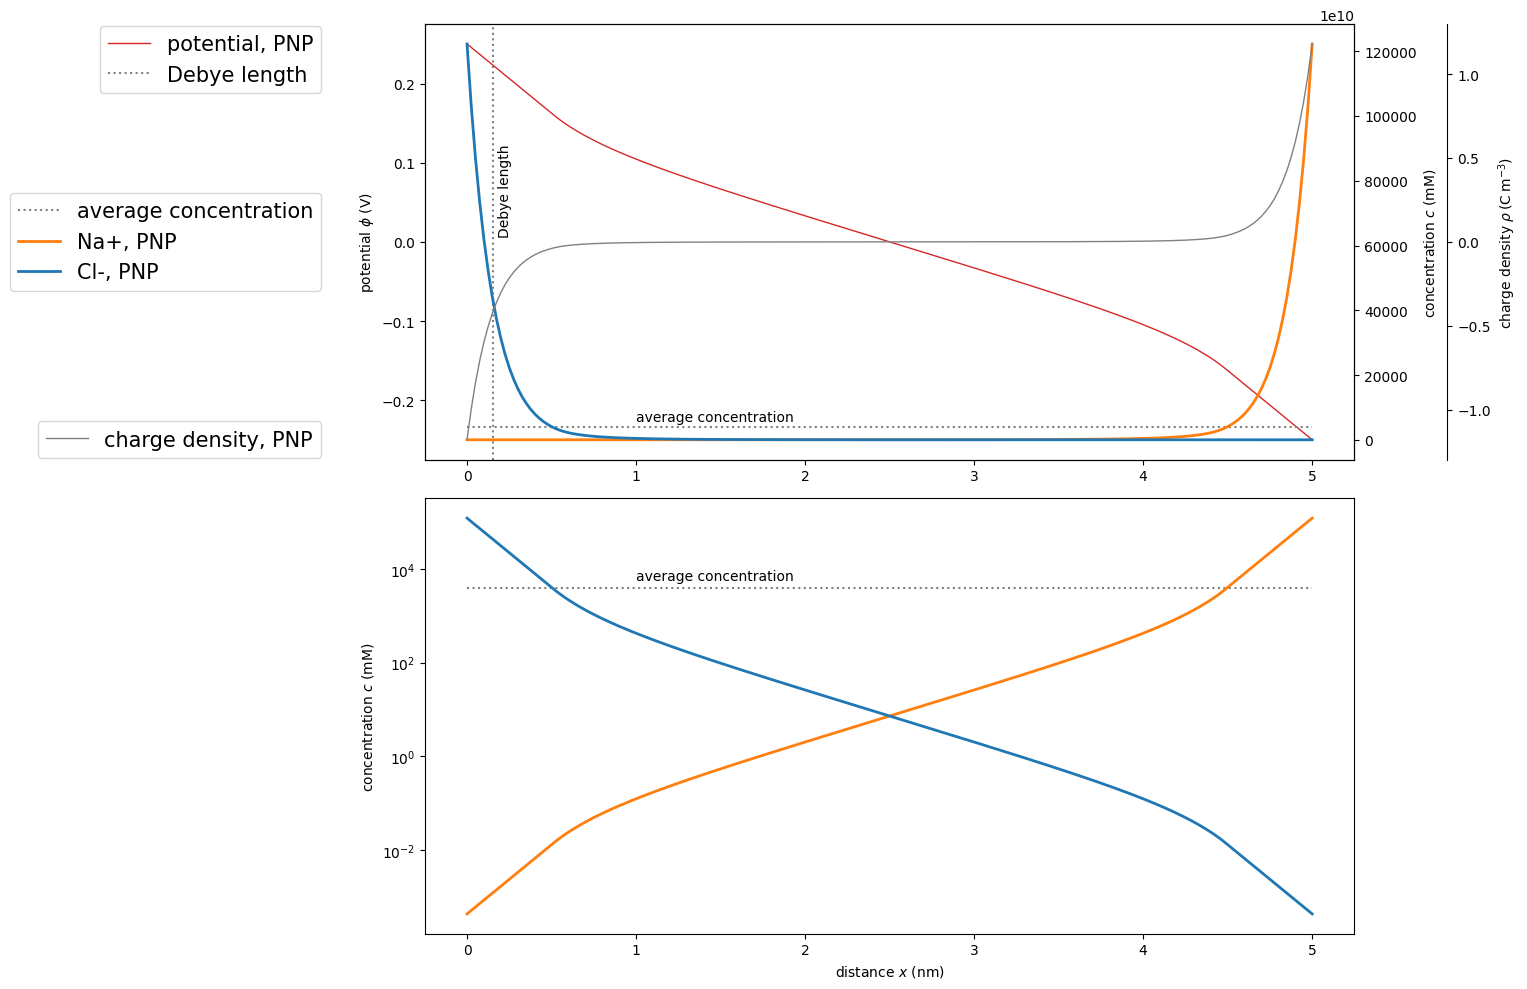

In [20]:
x = np.linspace(0, L, 100)

deb = debye(c, z)

fig, (ax1,ax4) = plt.subplots(nrows=2,ncols=1,figsize=[16,10])
ax1.plot(pnp.grid/sc.nano, pnp.potential, marker='', color='tab:red', label='potential, PNP', linewidth=1, linestyle='-')

ax2 = ax1.twinx()
ax2.plot(x/sc.nano, np.ones(x.shape)*c[0], label='average concentration', color='grey', linestyle=':')
ax2.text(1, c[0]*1.5, "average concentration")

ax2.plot(pnp.grid/sc.nano, pnp.concentration[0], marker='', color='tab:orange', label='Na+, PNP', linewidth=2, linestyle='-')

ax2.plot(pnp.grid/sc.nano, pnp.concentration[1], marker='', color='tab:blue', label='Cl-, PNP', linewidth=2, linestyle='-')
ax1.axvline(x=deb/sc.nano, label='Debye length', color='grey', linestyle=':')
ax1.text(deb/sc.nano*1.2, 0.01, "Debye length", rotation=90)

ax3 = ax1.twinx()
ax3.spines["right"].set_position(("axes", 1.1))
make_patch_spines_invisible(ax3)

ax3.spines["right"].set_visible(True)
ax3.plot(pnp.grid/sc.nano, pnp.charge_density, label='charge density, PNP', color='grey', linewidth=1, linestyle='-')

ax4.semilogy(x/sc.nano, np.ones(x.shape)*c[0], label='average concentration', color='grey', linestyle=':')
ax4.text(1, c[0]*1.5, "average concentration")
ax4.semilogy(pnp.grid/sc.nano, pnp.concentration[0], marker='', color='tab:orange', label='Na+, PNP', linewidth=2, linestyle='-')
ax4.semilogy(pnp.grid/sc.nano, pnp.concentration[1], marker='', color='tab:blue', label='Cl-, PNP', linewidth=2, linestyle='-')

ax1.set_ylabel('potential $\phi$ (V)')
ax2.set_ylabel('concentration $c$ (mM)')
ax3.set_ylabel(r'charge density $\rho \> (\mathrm{C}\> \mathrm{m}^{-3})$')
ax4.set_ylabel('concentration $c$ (mM)')
ax4.set_xlabel('distance $x$ (nm)')

ax1.legend(loc='upper right',  bbox_to_anchor=(-0.1,1.02), fontsize=15)
ax2.legend(loc='center right', bbox_to_anchor=(-0.1,0.5),  fontsize=15)
ax3.legend(loc='lower right',  bbox_to_anchor=(-0.1,-0.02), fontsize=15)

fig.tight_layout()
plt.show()

Notice the nealry linear behavior of potential close to the electrodes arising from the Robin boundary conditions.

## Sampling from continuous distributions

We want to generate three-dimensional atomistic configurations from the one-dimensional concentration distributions retrieved above. `matscipy.electrochemistry` provides the sampling interface `continuous2discrete` for this purpose.

In [21]:
from matscipy.electrochemistry import continuous2discrete

`continuous2discrete` expects a callable distribution function. Hence, we convert the physical concentration distributions into callable density functions.

In [22]:
from scipy import interpolate
distributions = [interpolate.interp1d(pnp.grid,pnp.concentration[i,:]) for i in range(pnp.concentration.shape[0])]

Normalization is not necessary here. Now we can sample the distribution of our $Na^+$ ions in z-direction.

In [23]:
na_coordinate_sample = continuous2discrete(distribution=distributions[0], box=box_m, count=n_NaCl)

`matscipy.electrochemistry` provides the utility function `get_histogram` to count coordinate sets within bins along all three spatial dimensions.

In [24]:
from matscipy.electrochemistry import get_histogram
histx, histy, histz = get_histogram(na_coordinate_sample, box=box_m, n_bins=51)

For visulaization purposes, we define two little helper functions.

In [25]:
# helper functions
def get_centers(bins):
    """Return the center of the provided bins.

    Example:
    >>> get_centers(bins=np.array([0.0, 1.0, 2.0]))
    array([ 0.5,  1.5])
    """
    bins = bins.astype(float)
    return (bins[:-1] + bins[1:]) / 2

def plot_dist(histogram, name, reference_distribution=None):
    """Plot histogram with an optional reference distribution."""
    hist, bins = histogram
    width = 1 * (bins[1] - bins[0])
    centers = get_centers(bins)

    fi, ax = plt.subplots()
    ax.bar( centers, hist, align='center', width=width, label='Empirical distribution',
            edgecolor="none")

    if reference_distribution is not None:
        ref = reference_distribution(centers)
        ref /= sum(ref)
        ax.plot(centers, ref, color='red', label='Target distribution')

    ax.set_title(name)
    ax.legend()
    ax.set_xlabel('Distance ' + name)

Eventually, we show the distribution of samples sodium ions along the non-uniform z-direction.

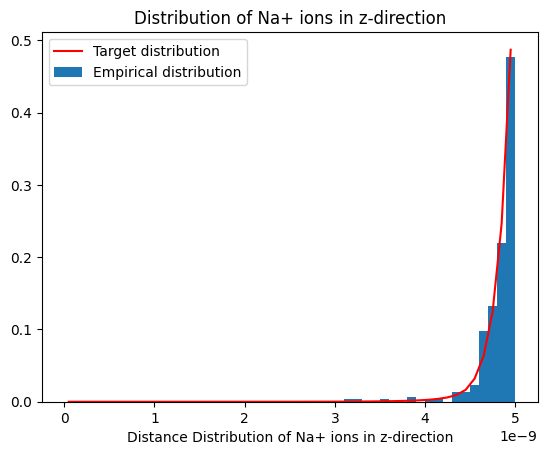

In [26]:
plot_dist(histz, 'Distribution of Na+ ions in z-direction', reference_distribution=distributions[0])

Similarly, we sample chlorine ions...

In [27]:
cl_coordinate_sample = continuous2discrete(distributions[1], box=box_m, count=n_NaCl)

... and show their distribution ...

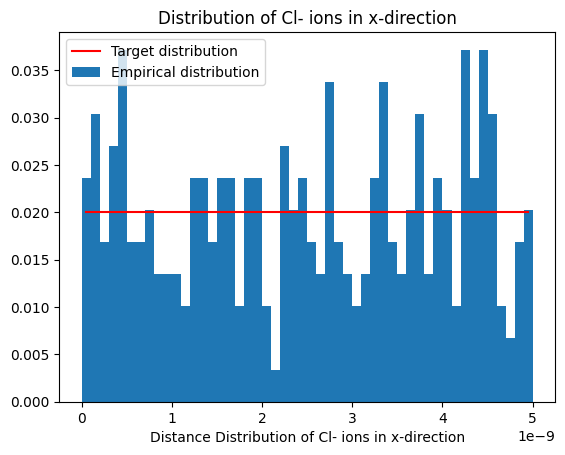

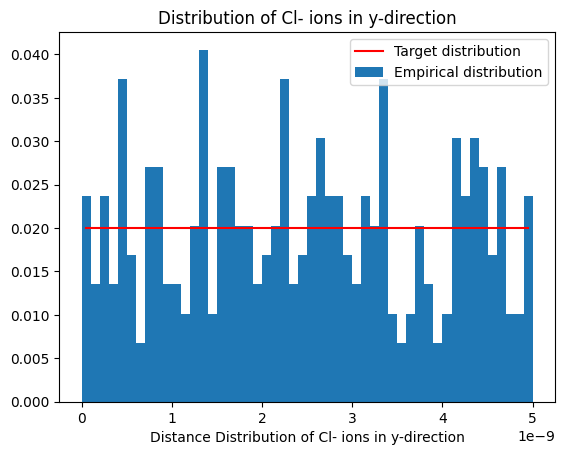

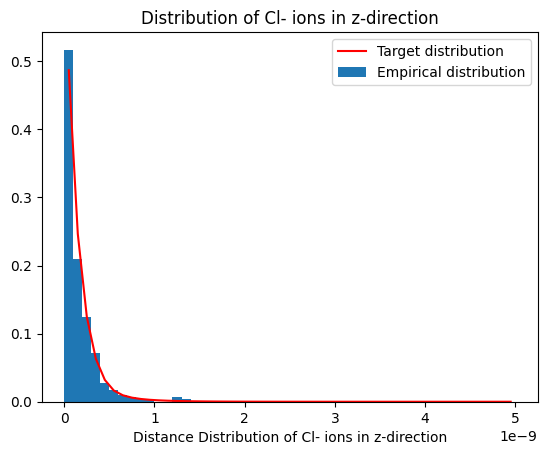

In [28]:
histx, histy, histz = get_histogram(cl_coordinate_sample, box=box_m, n_bins=51)
plot_dist(histx, 'Distribution of Cl- ions in x-direction', reference_distribution=lambda x: np.ones(x.shape)*1/box_m[0])
plot_dist(histy, 'Distribution of Cl- ions in y-direction', reference_distribution=lambda x: np.ones(x.shape)*1/box_m[1])
plot_dist(histz, 'Distribution of Cl- ions in z-direction', reference_distribution=distributions[1])

Notice the uniform distribution along x- and y-direction.

### Coordinates export
Everntually, we use ASE to export our sample to some standard format, i.e. .xyz or LAMMPS data file.

In [29]:
import ase
import ase.io

ASE speaks Ångström per default, thus we convert our SI units:

In [ ]:
sample_size = int(n_NaCl)

na_atoms = ase.Atoms(
    symbols='Na'*sample_size,
    charges=[1]*sample_size,
    positions=na_coordinate_sample/sc.angstrom,
    cell=box_Ang,
    pbc=[1,1,0])

cl_atoms = ase.Atoms(
    symbols='Cl'*sample_size,
    charges=[-1]*sample_size,
    positions=cl_coordinate_sample/sc.angstrom,
    cell=box_Ang,
    pbc=[1,1,0])

system = na_atoms + cl_atoms

ase.io.write('NaCl_c_4_M_u_0.5_V_box_5x5x5nm_lambda_S_5_Ang.xyz', system, format='xyz')

# LAMMPS data format, units 'real', atom style 'full'
# before ASE 3.19.0b1, ASE had issues with exporting atom style 'full' in LAMMPS data file format, so do not expect this line to work for older ASE versions
ase.io.write('NaCl_c_4_M_u_0.5_V_box_5x5x5nm_lambda_S_5_Ang.lammps', system,
             format='lammps-data', units="real", atom_style='full')

# Acknowledgements

We thank Lukas Elflein for supporting the development of `matscipy.electrochemistry` and the according example notebooks. We thank Andreas Greiner for discussions and inspirations on solving transport problems with controlled-volume and finte-elements methods.

# References

<a id='bazant2006'></a>[1] M. Z. Bazant, K. T. Chu, and B. J. Bayly, “Current-Voltage Relations for Electrochemical Thin Films,” SIAM Journal on Applied Mathematics, Jul. 2006, doi: [10.1137/040609938](https://doi.org/10.1137/040609938).

<a id='stern1924'></a>[2] O. Stern, “Zur Theorie Der Elektrolytischen Doppelschicht,” Zeitschrift für Elektrochemie und angewandte physikalische Chemie, vol. 30, no. 21–22, pp. 508–516, 1924, doi: [10.1002/bbpc.192400182](https://doi.org/10.1002/bbpc.192400182).

<a id='israelachvili1991'></a>[3] J. N. Israelachvili, Intermolecular and surface forces. Academic Press, London, 1991.